In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

Loading the dataset.  This is a dataset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/).

In [4]:
import numpy as np
import struct
from array import array
from os.path  import join


# MNIST Data Loader Class

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

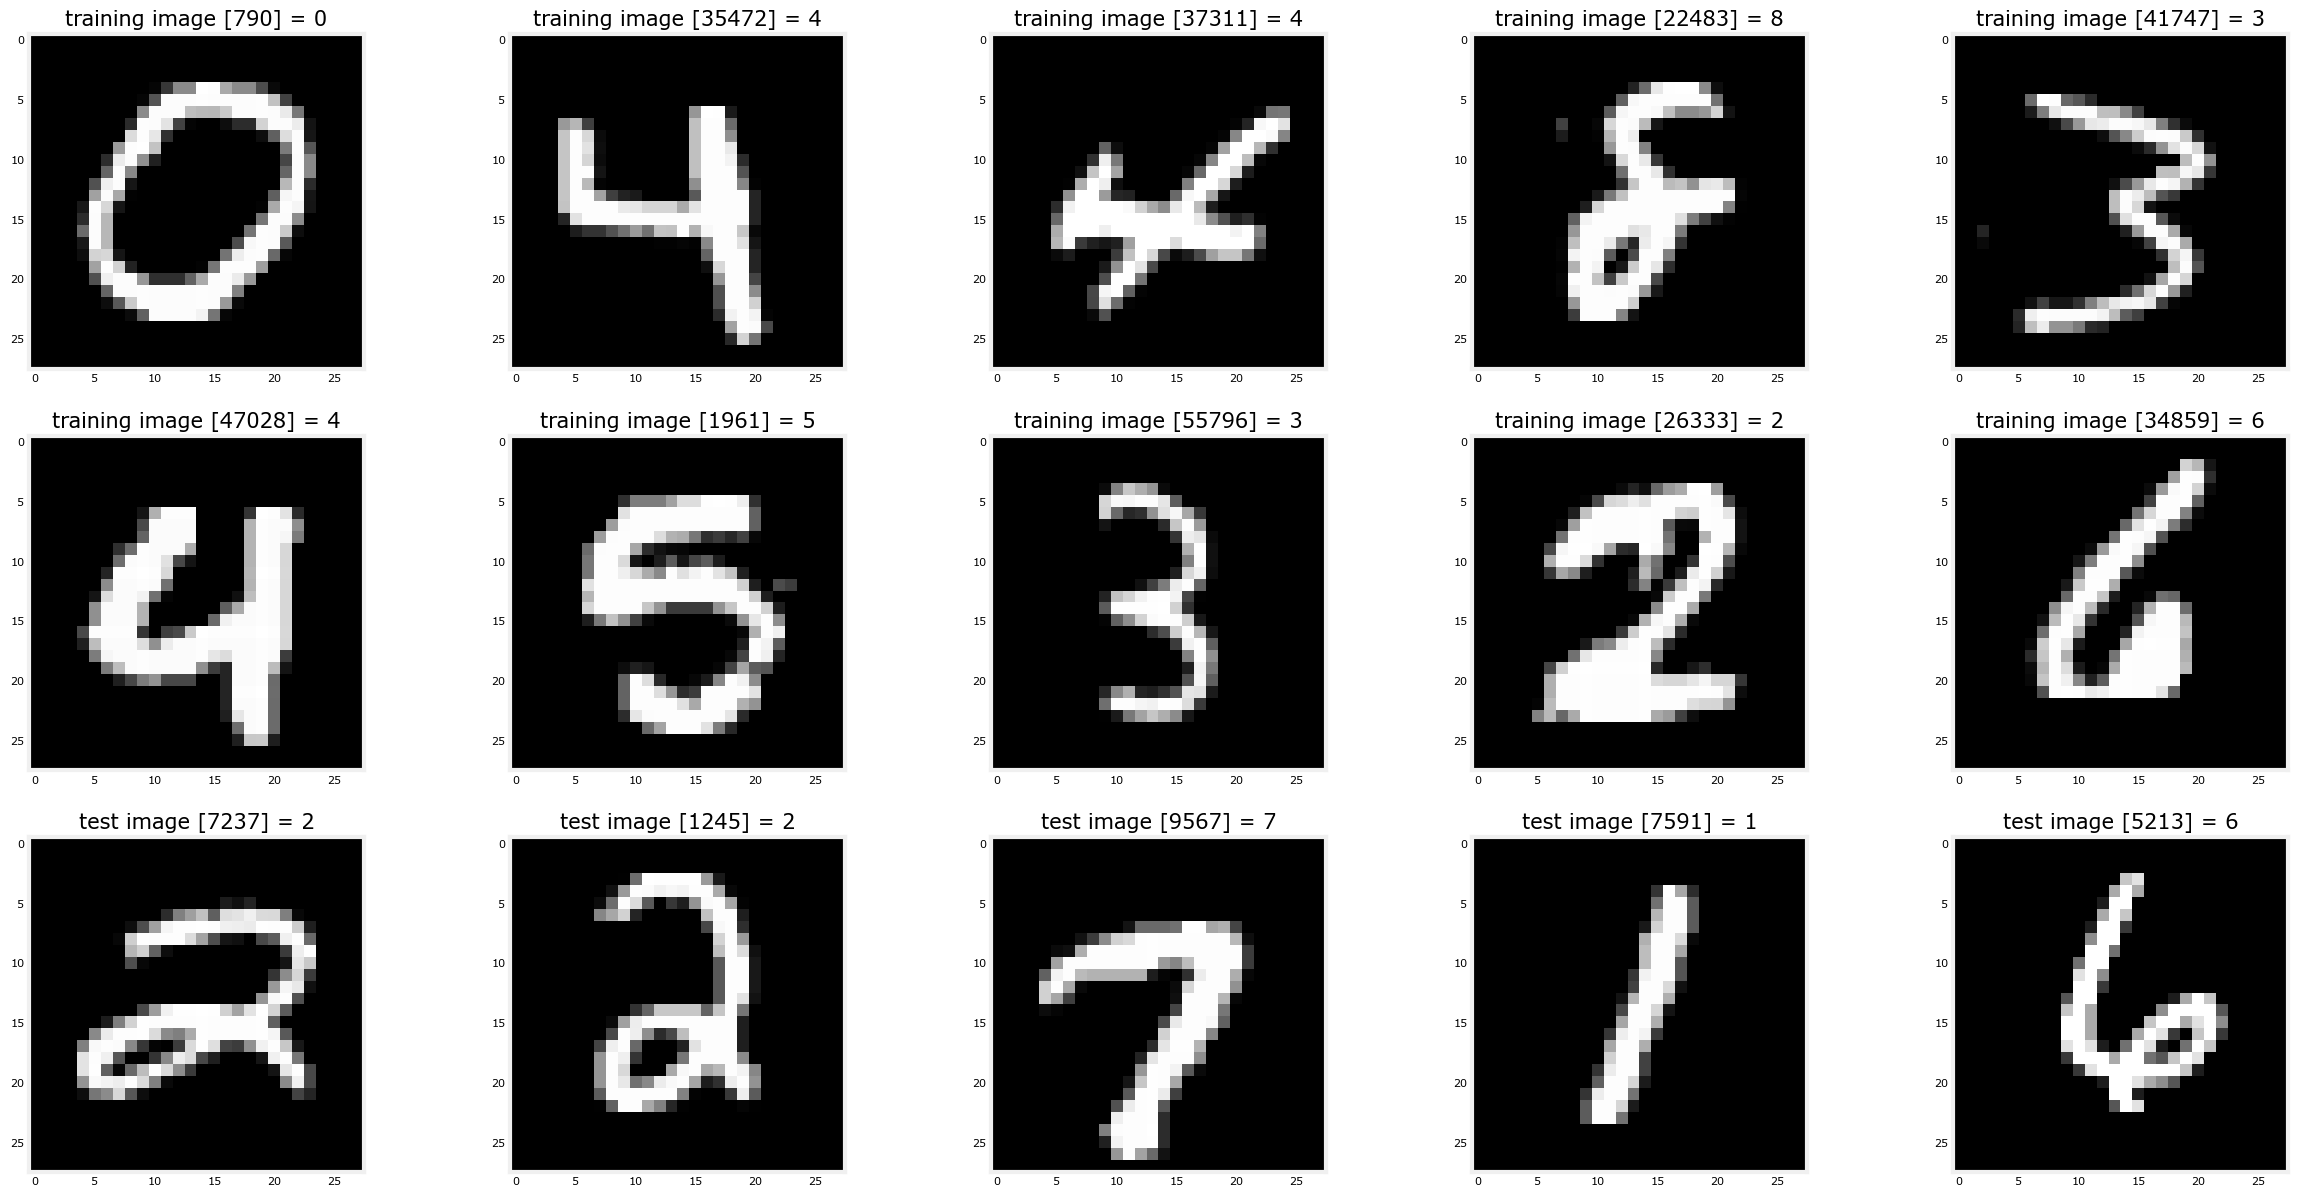

In [19]:

# Verify Reading Dataset via MnistDataloader class

%matplotlib inline
import random
import matplotlib.pyplot as plt

# Set file paths based on added MNIST Datasets

input_path = 'data'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [ ]:
show the size of the data

In [26]:
print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [29]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


In [30]:
# Normalize the images.
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Reshape the images to add a channel dimension (required for CNNs)
# Assuming x_train and x_test are lists of numpy arrays:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

model configuration

In [33]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
], name = "my_model"
) 

model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                102

In [34]:
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    x_train, np.array(y_train),
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
1688/1688 [==============================] - 21s 12ms/step - loss: 0.1428 - accuracy: 0.9580 - val_loss: 0.0646 - val_accuracy: 0.9822
Epoch 2/10
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0489 - accuracy: 0.9846 - val_loss: 0.0504 - val_accuracy: 0.9860
Epoch 3/10
1688/1688 [==============================] - 21s 13ms/step - loss: 0.0333 - accuracy: 0.9894 - val_loss: 0.0334 - val_accuracy: 0.9905
Epoch 4/10
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0244 - accuracy: 0.9920 - val_loss: 0.0359 - val_accuracy: 0.9895
Epoch 5/10
1688/1688 [==============================] - 21s 12ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0364 - val_accuracy: 0.9895
Epoch 6/10
1688/1688 [==============================] - 21s 12ms/step - loss: 0.0148 - accuracy: 0.9946 - val_loss: 0.0450 - val_accuracy: 0.9903
Epoch 7/10
1688/1688 [==============================] - 21s 12ms/step - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.0421 -

In [36]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


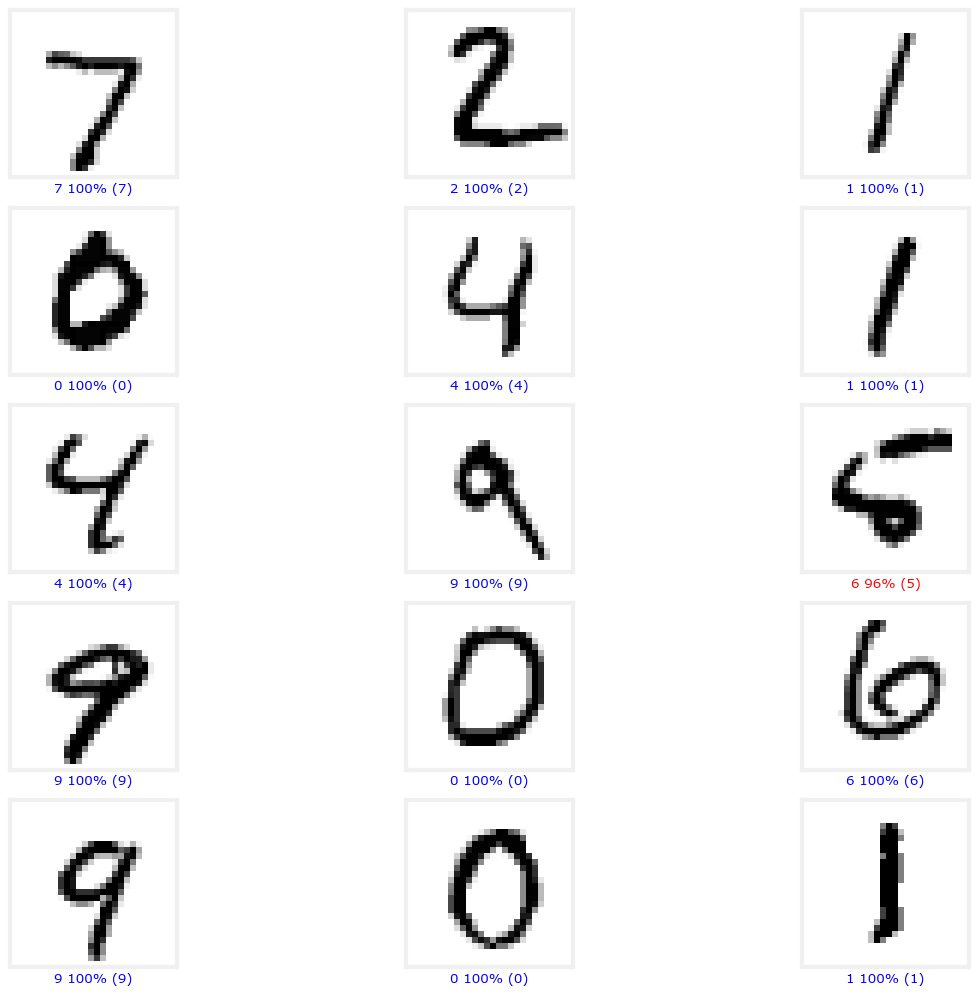

In [37]:
# Function to plot images and their labels
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i].reshape(28,28)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_image(i, predictions[i], np.array(y_test), np.array(x_test))
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(x_test)

In [ ]:
# Function to plot images and their labels
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i].reshape(28,28)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_image(i, predictions[i], np.array(y_test), np.array(x_test))
plt.tight_layout()
plt.show()

In [38]:
model.save('mnist_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
